# Mounting Google Drive

To begin, we need to access our dataset stored in Google Drive. By mounting the drive, we can easily load the data into our notebook. This step ensures that we can work with the files stored in our Google Drive directly from this environment.

In [ ]:
from google.colab import drive

drive.mount("/content/drive")


Mounted at /content/drive


# Importing Libraries and Setting Configurations

In this section, we import the necessary libraries for data manipulation, visualization, and machine learning. We also define some configuration options to control the behavior of our analysis, such as the number of top actors, roles, and companies to consider. Additionally, we configure the plotting style to make our visualizations more appealing and set display options for pandas to view all columns and rows when needed.

In [ ]:
import pandas as pd
import numpy as np
import re
import ast
from collections import Counter, defaultdict
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration Options
TOP_N_ACTORS = 150
TOP_M_ROLES = 5
TOP_N_PER_ROLE = 100
TOP_N_COMPANIES = 200
MAX_SYNOPSIS_FEATURES = 1000
VIS_TOP_N = 15

# Plotting Configuration
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 7)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 12
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

# Defining Helper Functions

Here, we define several helper functions to clean and preprocess our data. These functions handle tasks such as:
- Cleaning currency values to convert them into numeric format.
- Extracting numeric values from text fields like production budgets and running times.
- Counting keywords in a string.
- Safely evaluating strings that represent Python literals (e.g., lists or dictionaries).
- Cleaning text for TF-IDF vectorization by removing special characters and numbers.

These functions will be used throughout the notebook to ensure our data is clean and ready for analysis.

In [ ]:
# Helper Functions
def clean_currency(value):
    if pd.isna(value):
        return np.nan
    value_str = str(value).replace("$", "").replace(",", "").strip()
    return pd.to_numeric(value_str, errors="coerce")


def clean_production_budget(value):
    if pd.isna(value):
        return np.nan
    value_str = str(value)
    match = re.match(r"^\$?([0-9,]+)", value_str)
    if match:
        budget_str = match.group(1).replace(",", "")
        return pd.to_numeric(budget_str, errors="coerce")
    return np.nan


def clean_running_time(value):
    if pd.isna(value):
        return np.nan
    value_str = str(value)
    match = re.match(r"(\d+)\s*minutes?", value_str, re.IGNORECASE)
    if match:
        return pd.to_numeric(match.group(1), errors="coerce")
    return np.nan


def count_keywords(value):
    if pd.isna(value) or value == "":
        return 0
    parts = str(value).split(" / ")
    count = 0
    for part in parts:
        count += len([kw for kw in part.split(",") if kw.strip()])
    return count


def safe_literal_eval_revised(value):
    if pd.isna(value):
        return None
    value_str = str(value).strip()
    try:
        if (value_str.startswith("[") and value_str.endswith("]")) or (
            value_str.startswith("{") and value_str.endswith("}")
        ):
            return ast.literal_eval(value_str)
        return None
    except (ValueError, SyntaxError, TypeError, MemoryError, RecursionError):
        return None


def clean_text_for_tfidf(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    return text


cleaning_pattern = r"\W|^(?=\d)"

# Download NLTK Stopwords
try:
    stop_words = stopwords.words("english")
except LookupError:
    nltk.download("stopwords")
    stop_words = stopwords.words("english")


--- 1. Data Loading and Initial Inspection ---
Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4625 entries, 0 to 4624
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   synopsis                        3788 non-null   object
 1   opening_weekend                 3681 non-null   object
 2   percent_of_total_gross          3681 non-null   object
 3   production_budget               3190 non-null   object
 4   domestic_release_date           3879 non-null   object
 5   running_time                    4296 non-null   object
 6   keywords                        4056 non-null   object
 7   source                          4528 non-null   object
 8   genre                           4570 non-null   object
 9   production_method               4568 non-null   object
 10  creative_type                   4537 non-null   object
 11  production_financing_companies  3228 

# Loading and Inspecting the Data

Now, we load our dataset from Google Drive using pandas. After loading the data, we inspect its structure and contents by printing the DataFrame's information and displaying the first few rows. This step helps us understand the dataset's columns, data types, and any potential issues such as missing values.

In [ ]:
# Data Loading and Initial Inspection
print("--- 1. Data Loading and Initial Inspection ---")
df = pd.read_csv("/content/drive/MyDrive/updated_movies2.csv")
print("Initial DataFrame Info:")
df.info()
print("\nInitial DataFrame Head:")
print(df.head().to_markdown(numalign="left", stralign="left"))

# Create a copy for processing
df_processed = df.copy()

# Preprocessing the Data

In this section, we preprocess the data to prepare it for analysis and modeling. The steps include:
1. Cleaning the target variable (`opening_weekend`) by converting it to numeric format and dropping rows with missing values.
2. Removing columns that may cause data leakage or are irrelevant to our analysis.
3. Cleaning and imputing missing values in numerical columns like `production_budget` and `running_time`.
4. Extracting date-related features (e.g., year, month, day of the week) from the release date.
5. Handling missing values in categorical columns by filling them with "Unknown."
6. Creating new features, such as the count of keywords and the number of directors, based on complex columns.

These steps ensure that our dataset is clean, consistent, and enriched with meaningful features.

In [ ]:
print("\n--- 2. Data Preprocessing ---")

print("\nProcessing Target Variable: opening_weekend")
df_processed["opening_weekend"] = df_processed["opening_weekend"].apply(clean_currency)
initial_rows = len(df_processed)
df_processed.dropna(subset=["opening_weekend"], inplace=True)
print(f"Dropped {initial_rows - len(df_processed)} rows with missing opening_weekend.")
print(f"Shape after dropping missing target: {df_processed.shape}")

print("\nHandling Data Leakage and Irrelevant Columns")
cols_to_drop = ["percent_of_total_gross", "movie_url"]
for col in cols_to_drop:
    if col in df_processed.columns:
        df_processed.drop(col, axis=1, inplace=True)
        print(f"Dropped '{col}' column.")

print("\nProcessing Numerical Columns (Budget, Runtime)")
df_processed["production_budget_cleaned"] = df_processed["production_budget"].apply(
    clean_production_budget
)
median_budget = df_processed["production_budget_cleaned"].median()
df_processed["production_budget_cleaned"].fillna(median_budget, inplace=True)
print(f"Cleaned 'production_budget'. Missing imputed with median: {median_budget:,.0f}")
if "production_budget" in df_processed.columns:
    df_processed.drop("production_budget", axis=1, inplace=True)

df_processed["running_time_cleaned"] = df_processed["running_time"].apply(
    clean_running_time
)
mean_runtime = df_processed["running_time_cleaned"].mean()
df_processed["running_time_cleaned"].fillna(mean_runtime, inplace=True)
print(f"Cleaned 'running_time'. Missing imputed with mean: {mean_runtime:.2f}")
if "running_time" in df_processed.columns:
    df_processed.drop("running_time", axis=1, inplace=True)

print("\nProcessing Date Column: domestic_release_date")
if "domestic_release_date" in df_processed.columns:
    df_processed["release_date"] = pd.to_datetime(
        df_processed["domestic_release_date"], errors="coerce"
    )
    print(
        f"Missing release_date after conversion: {df_processed['release_date'].isna().sum()}"
    )

    df_processed["release_year"] = df_processed["release_date"].dt.year
    df_processed["release_month"] = df_processed["release_date"].dt.month
    df_processed["release_dayofweek"] = df_processed["release_date"].dt.dayofweek
    df_processed["release_dayofyear"] = df_processed["release_date"].dt.dayofyear

    for col in [
        "release_year",
        "release_month",
        "release_dayofweek",
        "release_dayofyear",
    ]:
        if df_processed[col].isna().any():
            mode_val = df_processed[col].mode()[0]
            df_processed[col].fillna(mode_val, inplace=True)
            print(f"Imputed missing '{col}' with mode: {mode_val}")
            df_processed[col] = df_processed[col].astype(int)
        elif pd.api.types.is_numeric_dtype(df_processed[col]):
            df_processed[col] = df_processed[col].astype(int)

    df_processed.drop(
        ["domestic_release_date", "release_date"], axis=1, inplace=True, errors="ignore"
    )
    print("Extracted date features and dropped original date columns.")
else:
    print("Column 'domestic_release_date' not found.")

print("\nProcessing Basic Categorical Columns")
basic_categorical_cols = [
    "source",
    "genre",
    "production_method",
    "creative_type",
    "production_countries",
    "languages",
]
for col in basic_categorical_cols:
    if col in df_processed.columns:
        original_missing = df_processed[col].isna().sum()
        df_processed[col].fillna("Unknown", inplace=True)
        if original_missing > 0:
            print(
                f"Filled {original_missing} missing values in '{col}' with 'Unknown'."
            )
    else:
        print(f"Categorical column '{col}' not found.")

print("\nProcessing Keywords count")
if "keywords" in df_processed.columns:
    df_processed["keywords_count"] = df_processed["keywords"].apply(count_keywords)
    df_processed.drop("keywords", axis=1, inplace=True)
    print("Created 'keywords_count' feature and dropped original.")
else:
    print("Column 'keywords' not found.")

if "synopsis" in df_processed.columns:
    df_processed.drop("synopsis", axis=1, inplace=True)
    print("Temporarily dropped 'synopsis'. Will process later.")

print("\nCreating df_aligned for accessing original complex/text data...")
df_aligned = df.loc[df_processed.index].copy()

complex_cols_for_counts = {
    "production_financing_companies": "num_financing_companies",
    "lead_ensemble_members": "num_lead_actors",
    "production_technical_credits": "num_technical_roles",
}

for original_col, new_col_name in complex_cols_for_counts.items():
    if original_col in df_processed.columns:
        print(f"Processing count for {original_col}...")
        parsed_data = df_aligned[original_col].apply(safe_literal_eval_revised)

        if new_col_name == "num_technical_roles":
            df_processed[new_col_name] = parsed_data.apply(
                lambda x: len(x.keys()) if isinstance(x, dict) else 0
            )
            df_processed["num_directors"] = parsed_data.apply(
                lambda x: len(x.get("Director", [])) if isinstance(x, dict) else 0
            )
            df_processed["num_directors"].fillna(0, inplace=True)
            df_processed["num_directors"] = df_processed["num_directors"].astype(int)
            print("Created 'num_directors' feature.")
        else:
            df_processed[new_col_name] = parsed_data.apply(
                lambda x: len(x) if isinstance(x, list) else 0
            )

        df_processed[new_col_name].fillna(0, inplace=True)
        df_processed[new_col_name] = df_processed[new_col_name].astype(int)
        print(f"Created '{new_col_name}' feature.")
        df_processed.drop(original_col, axis=1, inplace=True)
    else:
        print(f"Original complex column '{original_col}' not found.")

print("\n--- Preprocessing Complete ---")
df_processed.info()
print("\nMissing Values After Preprocessing:")
print(df_processed.isnull().sum())


--- 2. Data Preprocessing ---

Processing Target Variable: opening_weekend
Dropped 944 rows with missing opening_weekend.
Shape after dropping missing target: (3681, 18)

Handling Data Leakage and Irrelevant Columns
Dropped 'percent_of_total_gross' column.
Dropped 'movie_url' column.

Processing Numerical Columns (Budget, Runtime)
Cleaned 'production_budget'. Missing imputed with median: 35,000,000
Cleaned 'running_time'. Missing imputed with mean: 111.05

Processing Date Column: domestic_release_date
Missing release_date after conversion: 811
Imputed missing 'release_year' with mode: 2010.0
Imputed missing 'release_month' with mode: 12.0
Imputed missing 'release_dayofweek' with mode: 4.0
Imputed missing 'release_dayofyear' with mode: 359.0
Extracted date features and dropped original date columns.

Processing Basic Categorical Columns
Filled 10 missing values in 'source' with 'Unknown'.
Filled 3 missing values in 'genre' with 'Unknown'.
Filled 4 missing values in 'production_method' 

<ipython-input-4-0ffda7d15be5>:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed['production_budget_cleaned'].fillna(median_budget, inplace=True)
<ipython-input-4-0ffda7d15be5>:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(va

Created 'num_lead_actors' feature.
Processing count for production_technical_credits...
Created 'num_directors' feature.
Created 'num_technical_roles' feature.

--- Preprocessing Complete ---
<class 'pandas.core.frame.DataFrame'>
Index: 3681 entries, 0 to 4624
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   opening_weekend            3681 non-null   float64
 1   source                     3681 non-null   object 
 2   genre                      3681 non-null   object 
 3   production_method          3681 non-null   object 
 4   creative_type              3681 non-null   object 
 5   production_countries       3681 non-null   object 
 6   languages                  3681 non-null   object 
 7   movie_title                3681 non-null   object 
 8   production_budget_cleaned  3681 non-null   float64
 9   running_time_cleaned       3681 non-null   float64
 10  release_year               36

<ipython-input-4-0ffda7d15be5>:116: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed['num_directors'].fillna(0, inplace=True)
<ipython-input-4-0ffda7d15be5>:122: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

# Feature Engineering

Feature engineering is a crucial step in machine learning. Here, we enhance our dataset by:
1. Applying one-hot encoding to categorical columns to convert them into numerical format.
2. Encoding top actors, roles, and companies as binary features to capture their presence in each movie.
3. Processing the `synopsis` column using TF-IDF vectorization to extract meaningful text features.

These engineered features will help our model better understand the relationships in the data.

In [ ]:
# ==============================================================================
# --- 3. Feature Engineering ---
# ==============================================================================
print("\n--- 3. Feature Engineering ---")

# --- 3.1 One-Hot Encoding (Basic Categories) ---
print("\nApplying One-Hot Encoding...")
categorical_cols_to_encode = df_processed.select_dtypes(
    include="object"
).columns.tolist()
if "movie_title" in categorical_cols_to_encode:
    categorical_cols_to_encode.remove("movie_title")  # Exclude movie title

print(f"Categorical columns identified for OHE: {categorical_cols_to_encode}")

# Check Cardinality
high_cardinality_threshold = 50
print("Checking Cardinality:")
for col in categorical_cols_to_encode:
    num_unique = df_processed[col].nunique()
    print(f"  Column '{col}': {num_unique} unique values")
    if num_unique > high_cardinality_threshold:
        print(f"    -> Warning: High cardinality detected for '{col}'!")

df_encoded = pd.get_dummies(
    df_processed,
    columns=categorical_cols_to_encode,
    prefix=categorical_cols_to_encode,
    prefix_sep="_",
    drop_first=False,
    dummy_na=False,
)

print(f"Shape after OHE: {df_encoded.shape}")


# --- 3.2 Top-N / Role-Person Encoding ---
print("\nApplying Top-N / Role-Person Encoding...")

# Dictionary to hold all new feature columns from this step
new_features = {}

# --- 3.2.1 Process Lead Actors ---
print(f"Processing Top {TOP_N_ACTORS} Actors...")
actor_counter = Counter()
parsed_actors_col = "parsed_actors_data"  # Column in df_aligned holding parsed actors

if parsed_actors_col not in df_aligned.columns:
    if "lead_ensemble_members" in df_aligned.columns:
        df_aligned[parsed_actors_col] = df_aligned["lead_ensemble_members"].apply(
            safe_literal_eval_revised
        )
    else:
        df_aligned[parsed_actors_col] = pd.Series(
            [None] * len(df_aligned), index=df_aligned.index
        )

if not df_aligned[parsed_actors_col].isnull().all():
    parsed_actors_valid = df_aligned[parsed_actors_col].dropna()
    for list_of_dicts in parsed_actors_valid:
        if isinstance(list_of_dicts, list):
            for actor_dict in list_of_dicts:
                if isinstance(actor_dict, dict) and "actor" in actor_dict:
                    actor_name = actor_dict.get("actor")
                    if isinstance(actor_name, str):
                        cleaned_name = actor_name.strip()
                        if cleaned_name:
                            actor_counter.update([cleaned_name])  # Pass as list

    top_actors = [actor for actor, count in actor_counter.most_common(TOP_N_ACTORS)]
    print(f"Identified Top {len(top_actors)} Actors.")

    for actor in top_actors:
        cleaned_name_part = re.sub(cleaning_pattern, "_", actor)
        col_name = f"actor_{cleaned_name_part}"

        def check_actor(parsed_list, target_actor):
            if isinstance(parsed_list, list):
                for act_dict in parsed_list:
                    if isinstance(act_dict, dict):
                        act_name = act_dict.get("actor")
                        if (
                            isinstance(act_name, str)
                            and act_name.strip() == target_actor
                        ):
                            return 1
            return 0

        actor_series = df_aligned[parsed_actors_col].apply(
            lambda x: check_actor(x, actor)
        )
        new_features[col_name] = actor_series
    print(f"Generated {len(top_actors)} actor feature series.")
else:
    print("Skipping actor encoding due to missing data.")

# --- 3.2.2 Process Production Technical Credits (Roles and People) ---
print(
    f"\nProcessing Top {TOP_M_ROLES} Roles and Top {TOP_N_PER_ROLE} People per Role..."
)
parsed_credits_col = (
    "parsed_credits_data"  # Column in df_aligned holding parsed credits
)

if parsed_credits_col not in df_aligned.columns:
    if "production_technical_credits" in df_aligned.columns:
        df_aligned[parsed_credits_col] = df_aligned[
            "production_technical_credits"
        ].apply(safe_literal_eval_revised)
    else:
        df_aligned[parsed_credits_col] = pd.Series(
            [None] * len(df_aligned), index=df_aligned.index
        )

if not df_aligned[parsed_credits_col].isnull().all():
    parsed_credits_valid = df_aligned[parsed_credits_col].dropna()
    # Step 2a: Identify Top M Roles
    all_roles_counter = Counter()
    parsed_credits_valid.apply(
        lambda cred_dict: all_roles_counter.update(
            list(cred_dict.keys()) if isinstance(cred_dict, dict) else []
        )
    )
    selected_roles = [
        role for role, count in all_roles_counter.most_common(TOP_M_ROLES)
    ]
    print(f"Selected Top {len(selected_roles)} Roles for detailed analysis.")

    # Step 2b: Count Top N People for each Selected Role
    role_person_counters = {role: Counter() for role in selected_roles}
    for credit_dict in parsed_credits_valid:
        if isinstance(credit_dict, dict):
            for role, people in credit_dict.items():
                if role in selected_roles and isinstance(people, list):
                    cleaned_people = [str(p).strip() for p in people if str(p).strip()]
                    if cleaned_people:
                        role_person_counters[role].update(cleaned_people)

    # Step 2c: Generate Binary Features for Role-Person pairs
    total_role_person_features = 0
    for role in selected_roles:
        top_people_for_role = [
            person
            for person, count in role_person_counters[role].most_common(TOP_N_PER_ROLE)
        ]
        if not top_people_for_role:
            continue
        cleaned_role_part = re.sub(cleaning_pattern, "_", role)
        for person in top_people_for_role:
            cleaned_person_part = re.sub(cleaning_pattern, "_", person)
            col_name = f"{cleaned_role_part}_{cleaned_person_part}"

            def check_role_person(parsed_dict, target_role, target_person):
                if isinstance(parsed_dict, dict) and target_role in parsed_dict:
                    personnel = parsed_dict.get(target_role)
                    if isinstance(personnel, list):
                        cleaned_personnel = [
                            str(p).strip() for p in personnel if str(p).strip()
                        ]
                        return 1 if target_person in cleaned_personnel else 0
                return 0

            role_person_series = df_aligned[parsed_credits_col].apply(
                lambda x: check_role_person(x, role, person)
            )
            new_features[col_name] = role_person_series
            total_role_person_features += 1
    print(f"Generated {total_role_person_features} role-person feature series.")
else:
    print("Skipping role-person encoding due to missing data.")


# --- 3.2.3 Process Production Companies ---
print(f"\nProcessing Top {TOP_N_COMPANIES} Companies...")
company_counter = Counter()
parsed_companies_col = "parsed_companies_data"  # Column in df_aligned

if parsed_companies_col not in df_aligned.columns:
    if "production_financing_companies" in df_aligned.columns:
        df_aligned[parsed_companies_col] = df_aligned[
            "production_financing_companies"
        ].apply(safe_literal_eval_revised)
    else:
        df_aligned[parsed_companies_col] = pd.Series(
            [None] * len(df_aligned), index=df_aligned.index
        )

if not df_aligned[parsed_companies_col].isnull().all():
    parsed_companies_valid = df_aligned[parsed_companies_col].dropna()
    for company_list in parsed_companies_valid:
        if isinstance(company_list, list):
            cleaned_companies = [str(c).strip() for c in company_list if str(c).strip()]
            if cleaned_companies:
                company_counter.update(cleaned_companies)

    top_companies = [
        company for company, count in company_counter.most_common(TOP_N_COMPANIES)
    ]
    print(f"Identified Top {len(top_companies)} Companies.")

    for company in top_companies:
        cleaned_name_part = re.sub(cleaning_pattern, "_", company)
        col_name = f"company_{cleaned_name_part}"

        def check_company(parsed_list, target_company):
            if isinstance(parsed_list, list):
                cleaned_list = [str(c).strip() for c in parsed_list if str(c).strip()]
                return 1 if target_company in cleaned_list else 0
            return 0

        company_series = df_aligned[parsed_companies_col].apply(
            lambda x: check_company(x, company)
        )
        new_features[col_name] = company_series
    print(f"Generated {len(top_companies)} company feature series.")
else:
    print("Skipping company encoding due to missing data.")

# --- 3.2.4 Combine Top-N Features ---
print("\nCombining Top-N features...")
if new_features:  # Only proceed if any new features were generated
    new_features_df = pd.DataFrame(new_features)
    print(
        f"Created DataFrame with {new_features_df.shape[1]} new Top-N/Role-Person features."
    )

    # Ensure indices match before concatenation (should match by design)
    if not df_encoded.index.equals(new_features_df.index):
        print(
            "WARNING: Index mismatch between df_encoded and new_features_df! Attempting reindex."
        )
        new_features_df = new_features_df.reindex(
            df_encoded.index
        )  # Potential NaNs if index missing

    df_encoded_final = pd.concat([df_encoded, new_features_df], axis=1)
    print(f"Shape after adding Top-N/Role-Person features: {df_encoded_final.shape}")
else:
    print("No new Top-N/Role-Person features generated, df_encoded remains unchanged.")
    df_encoded_final = df_encoded.copy()  # Use the OHE version

# Defragment
df_encoded_final = df_encoded_final.copy()


# --- 3.3 Synopsis Processing (TF-IDF) ---
print("\nProcessing Synopsis with TF-IDF...")
# Use df_aligned to get synopsis corresponding to the final rows
if "synopsis" not in df_aligned.columns:
    print("Error: 'synopsis' column not found in df_aligned. Cannot process synopsis.")
    df_final_with_synopsis = df_encoded_final.copy()  # Use the previous version
else:
    synopsis_series = df_aligned.loc[df_encoded_final.index, "synopsis"]
    synopsis_series_filled = synopsis_series.fillna("").astype(str)
    print(f"Filled {synopsis_series.isnull().sum()} missing synopsis values.")

    print("Cleaning synopsis text...")
    synopsis_cleaned = synopsis_series_filled.apply(clean_text_for_tfidf)

    print(f"Vectorizing text using TF-IDF (max_features={MAX_SYNOPSIS_FEATURES})...")
    vectorizer = TfidfVectorizer(
        max_features=MAX_SYNOPSIS_FEATURES,
        stop_words=stop_words,
        ngram_range=(1, 1),  # Start with unigrams
    )
    tfidf_matrix = vectorizer.fit_transform(synopsis_cleaned)
    print(f"Created TF-IDF matrix shape: {tfidf_matrix.shape}")

    tfidf_feature_names = vectorizer.get_feature_names_out()
    tfidf_df = pd.DataFrame(
        tfidf_matrix.toarray(),
        columns=[f"syn_{name}" for name in tfidf_feature_names],
        index=df_encoded_final.index,
    )
    print(f"Created TF-IDF DataFrame shape: {tfidf_df.shape}")

    print("Combining TF-IDF features...")
    # Ensure indices match
    if not df_encoded_final.index.equals(tfidf_df.index):
        print(
            "WARNING: Index mismatch between df_encoded_final and tfidf_df! Attempting reindex."
        )
        tfidf_df = tfidf_df.reindex(
            df_encoded_final.index, fill_value=0
        )  # Fill missing synopsis rows with 0

    # Ensure no column name conflicts
    common_cols = df_encoded_final.columns.intersection(tfidf_df.columns)
    if not common_cols.empty:
        print(
            f"Warning: Overlapping columns found and dropped from tfidf_df: {common_cols.tolist()}"
        )
        tfidf_df.drop(columns=common_cols, inplace=True, errors="ignore")

    df_final_with_synopsis = pd.concat([df_encoded_final, tfidf_df], axis=1)
    df_final_with_synopsis = df_final_with_synopsis.copy()  # Defragment
    print(
        f"Final DataFrame shape including synopsis features: {df_final_with_synopsis.shape}"
    )

# --- Drop movie_title before modeling (usually not a direct predictor) ---
if "movie_title" in df_final_with_synopsis.columns:
    df_final_with_synopsis.drop("movie_title", axis=1, inplace=True)
    print("Dropped 'movie_title' column.")

print("\n--- Feature Engineering Complete ---")
df_final_with_synopsis.info()



--- 3. Feature Engineering ---

Applying One-Hot Encoding...
Categorical columns identified for OHE: ['source', 'genre', 'production_method', 'creative_type', 'production_countries', 'languages']
Checking Cardinality:
  Column 'source': 22 unique values
  Column 'genre': 15 unique values
  Column 'production_method': 7 unique values
  Column 'creative_type': 10 unique values
  Column 'production_countries': 195 unique values
    -> Warning: High cardinality detected for 'production_countries'!
  Column 'languages': 158 unique values
    -> Warning: High cardinality detected for 'languages'!
Shape after OHE: (3681, 420)

Applying Top-N / Role-Person Encoding...
Processing Top 150 Actors...
Identified Top 150 Actors.
Generated 150 actor feature series.

Processing Top 5 Roles and Top 100 People per Role...
Selected Top 5 Roles for detailed analysis.
Generated 500 role-person feature series.

Processing Top 200 Companies...
Identified Top 200 Companies.
Generated 200 company feature seri

# Data Visualization

Visualization helps us explore and understand the data. In this section, we:
1. Analyze the distribution of the target variable (`opening_weekend`) and its log-transformed version.
2. Visualize numerical features to understand their distributions and relationships with the target variable.
3. Explore categorical features to identify trends and patterns.
4. Analyze time-based features, such as release year and month, to uncover temporal trends.
5. Examine correlations between key features and the target variable.

These visualizations provide valuable insights that guide our modeling decisions.

In [ ]:
# ==============================================================================
# --- 4. Data Visualization ---
# ==============================================================================
print("\n--- 4. Data Visualization ---")

# --- Create df_plot for visualizing original categories ---
# Use df_aligned which has original categories, merge necessary features
print("Preparing DataFrame for visualization...")
df_plot = df_aligned.loc[df_final_with_synopsis.index].copy()  # Ensure aligned index
# Add target and key numerical/date features needed for plotting
cols_to_merge = [
    "opening_weekend",
    "production_budget_cleaned",
    "running_time_cleaned",
    "keywords_count",
    "num_financing_companies",
    "num_lead_actors",
    "num_technical_roles",
    "num_directors",
    "release_year",
    "release_month",
    "release_dayofweek",
    "release_dayofyear",
]
# Add log-transformed versions used in plots
df_final_with_synopsis["opening_weekend_log"] = np.log1p(
    df_final_with_synopsis["opening_weekend"]
)
df_final_with_synopsis["production_budget_log"] = np.log1p(
    df_final_with_synopsis["production_budget_cleaned"]
)
cols_to_merge.extend(["opening_weekend_log", "production_budget_log"])

# Select only columns that actually exist in the final df
cols_to_merge = [col for col in cols_to_merge if col in df_final_with_synopsis.columns]

# Merge selected columns into df_plot
df_plot = pd.merge(
    df_plot,
    df_final_with_synopsis[cols_to_merge],
    left_index=True,
    right_index=True,
    how="left",
)
print("df_plot created for visualization.")

# --- 4.1 Target Variable Analysis ---
print("\nVisualizing Target Variable...")
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_final_with_synopsis["opening_weekend"], kde=True, bins=50)
plt.title("Distribution of Opening Weekend Gross")
plt.xlabel("Opening Weekend Gross ($)")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(df_final_with_synopsis["opening_weekend_log"], kde=True, bins=50)
plt.title("Distribution of Log(Opening Weekend Gross + 1)")
plt.xlabel("Log(Opening Weekend Gross + 1)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# --- 4.2 Numerical Feature Analysis ---
print("\nVisualizing Numerical Features...")
numerical_features_log = [
    "production_budget_log",
    "running_time_cleaned",
    "keywords_count",
    "num_financing_companies",
    "num_lead_actors",
    "num_technical_roles",
    "num_directors",
]
numerical_features_log = [
    col for col in numerical_features_log if col in df_final_with_synopsis.columns
]  # Ensure columns exist

# Histograms
df_final_with_synopsis[numerical_features_log].hist(
    bins=30, figsize=(15, 10), layout=(-1, 3)
)
plt.suptitle(
    "Distributions of Key Numerical Features (Using Log Budget)", y=1.02, fontsize=18
)
plt.tight_layout()
plt.show()

# Scatter plots vs Log Target
n_features = len(numerical_features_log)
n_cols_scat = 3
n_rows_scat = (n_features + n_cols_scat - 1) // n_cols_scat
plt.figure(figsize=(15, n_rows_scat * 4))
for i, col in enumerate(numerical_features_log):
    plt.subplot(n_rows_scat, n_cols_scat, i + 1)
    sns.scatterplot(
        x=df_final_with_synopsis[col],
        y=df_final_with_synopsis["opening_weekend_log"],
        alpha=0.4,
    )
    plt.title(f"Log(Opening Weekend) vs {col}")
    plt.xlabel(col)
    plt.ylabel("Log(Opening Weekend)")
plt.tight_layout()
plt.show()


# --- 4.3 Categorical Feature Analysis (Original) ---
print("\nVisualizing Original Categorical Features...")
original_categoricals_vis = [
    "source",
    "genre",
    "production_method",
    "creative_type",
    "production_countries",
    "languages",
]
original_categoricals_vis = [
    col for col in original_categoricals_vis if col in df_plot.columns
]  # Ensure columns exist


def plot_top_n_categorical(df, col_name, target_col, top_n=15):
    """Plots boxplots for the top N categories vs the target."""
    if col_name not in df.columns or target_col not in df.columns:
        print(
            f"Skipping plot: Column '{col_name}' or '{target_col}' not found in df_plot."
        )
        return
    plt.figure(figsize=(15, 7))
    top_categories = df[col_name].value_counts().nlargest(top_n).index
    df_filtered = df[df[col_name].isin(top_categories)]
    if df_filtered.empty:
        print(
            f"No data found for top {top_n} categories of '{col_name}'. Skipping plot."
        )
        plt.close()  # Close empty plot figure
        return
    try:  # Handle cases where median calculation might fail (e.g., all NaNs in target)
        order = (
            df_filtered.groupby(col_name)[target_col]
            .median()
            .sort_values(ascending=False)
            .index
        )
        sns.boxplot(
            data=df_filtered, x=col_name, y=target_col, order=order, showfliers=False
        )
    except Exception as e:
        print(f"Could not plot '{col_name}'. Error: {e}. Plotting without order.")
        sns.boxplot(
            data=df_filtered, x=col_name, y=target_col, showfliers=False
        )  # Fallback plot

    plt.title(f"{target_col} vs Top {top_n} {col_name}")
    plt.ylabel(target_col)
    plt.xlabel(col_name)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


for col in original_categoricals_vis:
    n_unique = df_plot[col].nunique()
    plot_top_n_categorical(
        df_plot, col, "opening_weekend_log", top_n=min(n_unique, VIS_TOP_N)
    )


# --- 4.4 Time-Based Analysis ---
print("\nVisualizing Time-Based Features...")
time_cols = ["release_year", "release_month", "release_dayofweek"]
if all(col in df_plot.columns for col in time_cols):
    plt.figure(figsize=(15, 12))
    # Trend over Years
    plt.subplot(2, 2, 1)
    df_plot.groupby("release_year")["opening_weekend_log"].median().plot(
        kind="line", marker="o"
    )
    plt.title("Median Log(Opening Weekend) by Release Year")
    plt.ylabel("Median Log(Opening Weekend)")
    plt.xlabel("Release Year")
    plt.grid(True)
    # By Month
    plt.subplot(2, 2, 2)
    sns.boxplot(
        data=df_plot, x="release_month", y="opening_weekend_log", showfliers=False
    )
    plt.title("Log(Opening Weekend) by Release Month")
    plt.xlabel("Month")
    plt.ylabel("Log(Opening Weekend)")
    # By Day of Week
    plt.subplot(2, 2, 3)
    day_map = {0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"}
    df_plot["release_day_name"] = df_plot["release_dayofweek"].map(day_map)
    sns.boxplot(
        data=df_plot,
        x="release_day_name",
        y="opening_weekend_log",
        order=day_map.values(),
        showfliers=False,
    )
    plt.title("Log(Opening Weekend) by Day of Week")
    plt.xlabel("Day of Week")
    plt.ylabel("Log(Opening Weekend)")
    # Count per year
    plt.subplot(2, 2, 4)
    sns.countplot(data=df_plot, x="release_year")
    plt.title("Number of Movies per Year")
    plt.xlabel("Release Year")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print(
        "Skipping time-based visualization as one or more required columns are missing."
    )


# --- 4.5 Correlation Analysis ---
print("\nVisualizing Correlations...")
# Use core numerical/count features + log target
cols_for_corr = [
    "opening_weekend_log",
    "production_budget_log",
    "running_time_cleaned",
    "keywords_count",
    "num_financing_companies",
    "num_lead_actors",
    "num_technical_roles",
    "num_directors",
    "release_year",
    "release_month",
    "release_dayofweek",
]
cols_for_corr = [
    col for col in cols_for_corr if col in df_final_with_synopsis.columns
]  # Ensure exist

if len(cols_for_corr) > 1:
    corr_matrix = df_final_with_synopsis[cols_for_corr].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Matrix of Key Features and Log(Target)")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough columns available for correlation heatmap.")


# --- 4.6 Analysis of Top N Feature Examples ---
print("\nVisualizing Top-N Feature Examples...")
example_prefixes = ["actor_", "company_"]
# Find one example role prefix (e.g., Director_, Producer_)
role_prefixes = [
    f"{re.sub(cleaning_pattern, '_', role)}_" for role in selected_roles[:2]
]  # Example 2 roles
example_prefixes.extend(role_prefixes)

example_top_n_cols = []
for prefix in example_prefixes:
    cols = [col for col in df_final_with_synopsis.columns if col.startswith(prefix)][
        :5
    ]  # Get up to 5 examples per prefix
    example_top_n_cols.extend(cols)

if not example_top_n_cols:
    print("Could not find example Top-N columns. Skipping visualization.")
else:
    n_cols_ex = 3
    n_rows_ex = (len(example_top_n_cols) + n_cols_ex - 1) // n_cols_ex
    plt.figure(figsize=(15, n_rows_ex * 4))
    for i, col in enumerate(example_top_n_cols):
        if col in df_final_with_synopsis.columns:
            plt.subplot(n_rows_ex, n_cols_ex, i + 1)
            sns.boxplot(
                data=df_final_with_synopsis,
                x=col,
                y="opening_weekend_log",
                showfliers=False,
            )
            # Clean title a bit more robustly
            title_part = col.split("_", 1)[1] if "_" in col else col
            plt.title(
                f"Log(Opening Weekend) by Presence of\n{title_part[:30]}{'...' if len(title_part) > 30 else ''}"
            )  # Limit title length
            plt.xlabel(f"Has Feature (0=No, 1=Yes)")
            plt.ylabel("Log(Opening Weekend)")
    plt.tight_layout()
    plt.show()

print("\n--- Data Visualization Complete ---")


Output hidden; open in https://colab.research.google.com to view.

# Frequency and Unique Count Analysis

In this section, we analyze the frequency of top features and count unique entities in the dataset. Specifically, we:
1. Identify the most frequent actors, companies, and roles in the dataset.
2. Count the number of unique actors and workers per role.

This analysis helps us understand the diversity and distribution of key entities in the dataset.


--- 5. Frequency and Unique Count Analysis ---

Analyzing Frequency of Top N Features...

Top 15 Most Frequent Actor Features:
actor_Nicolas_Cage         0.79
actor_Mark_Wahlberg        0.76
actor_Matt_Damon           0.71
actor_Johnny_Depp          0.71
actor_Robert_De_Niro       0.68
actor_Hugh_Jackman         0.68
actor_Tom_Hanks            0.68
actor_Liam_Neeson          0.68
actor_Jason_Statham        0.65
actor_Samuel_L__Jackson    0.62
actor_Denzel_Washington    0.62
actor_Dwayne_Johnson       0.62
actor_Colin_Farrell        0.62
actor_Ryan_Reynolds        0.60
actor_Ben_Affleck          0.57
dtype: float64


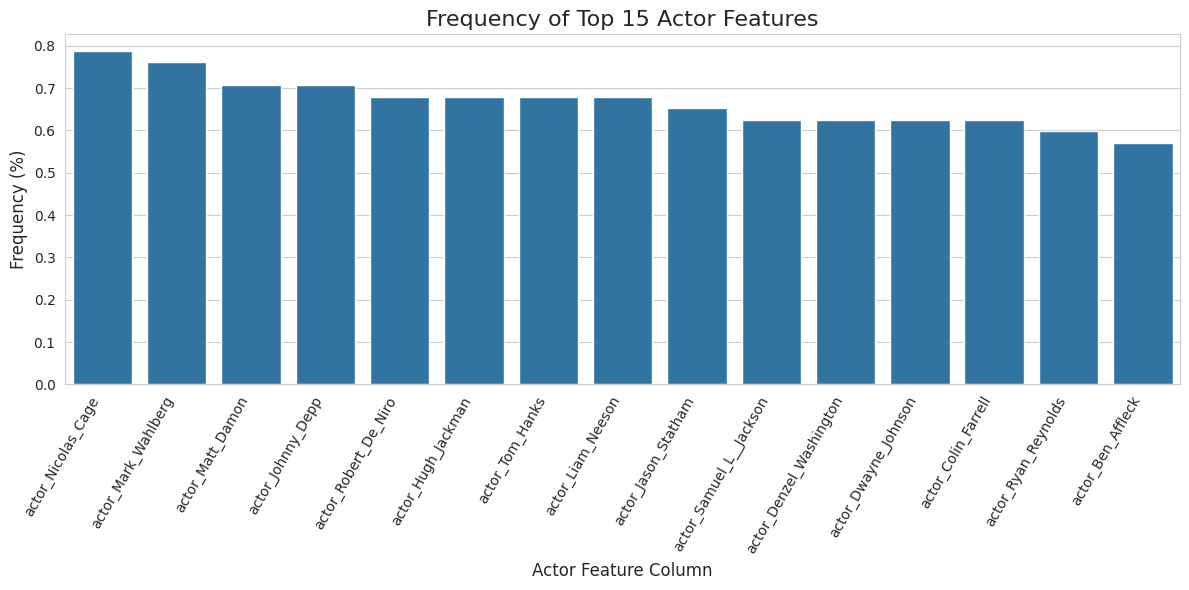


Top 15 Most Frequent Company Features:
company__20th_Century_Fox                    0.41
company_Sony_Pictures_Releasing              0.35
company_Buena_Vista_Pictures_Distribution    0.33
company_Universal_Pictures                   0.24
company_Warner_Bros__Pictures                0.24
company_Eros_International                   0.22
company_Fox_Searchlight_Pictures             0.19
company_Columbia_Pictures                    0.16
company_Miramax_Films                        0.16
company__International_                      0.16
company_Touchstone_Pictures                  0.14
company_UTV_Motion_Pictures                  0.11
company_New_Line_Cinema                      0.11
company_Paramount_Pictures                   0.11
company_Screen_Gems                          0.11
dtype: float64


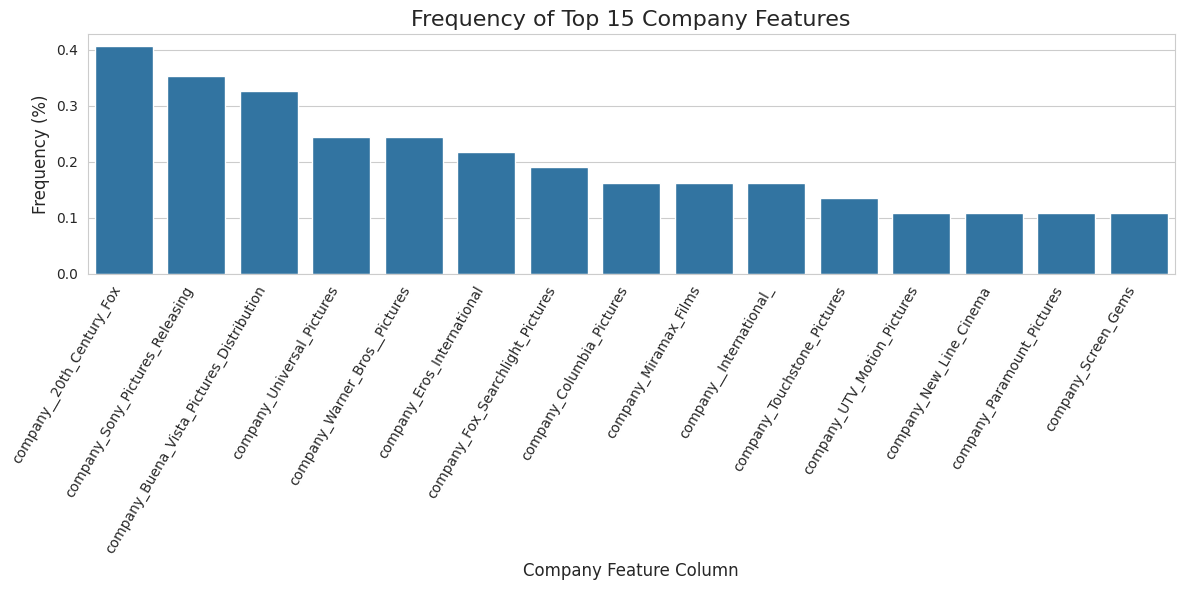


Top 15 Most Frequent Director Features:
Director_Tyler_Perry           0.54
Director_Ridley_Scott          0.52
Director_Woody_Allen           0.49
Director_Clint_Eastwood        0.49
Director_Steven_Soderbergh     0.43
Director_Steven_Spielberg      0.43
Director_M__Night_Shyamalan    0.35
Director_Robert_Rodriguez      0.35
Director_Shawn_Levy            0.35
Director_Guy_Ritchie           0.33
Director_Ron_Howard            0.33
Director_Tim_Burton            0.33
Director_Antoine_Fuqua         0.33
Director_Todd_Phillips         0.30
Director_Peter_Farrelly        0.30
dtype: float64


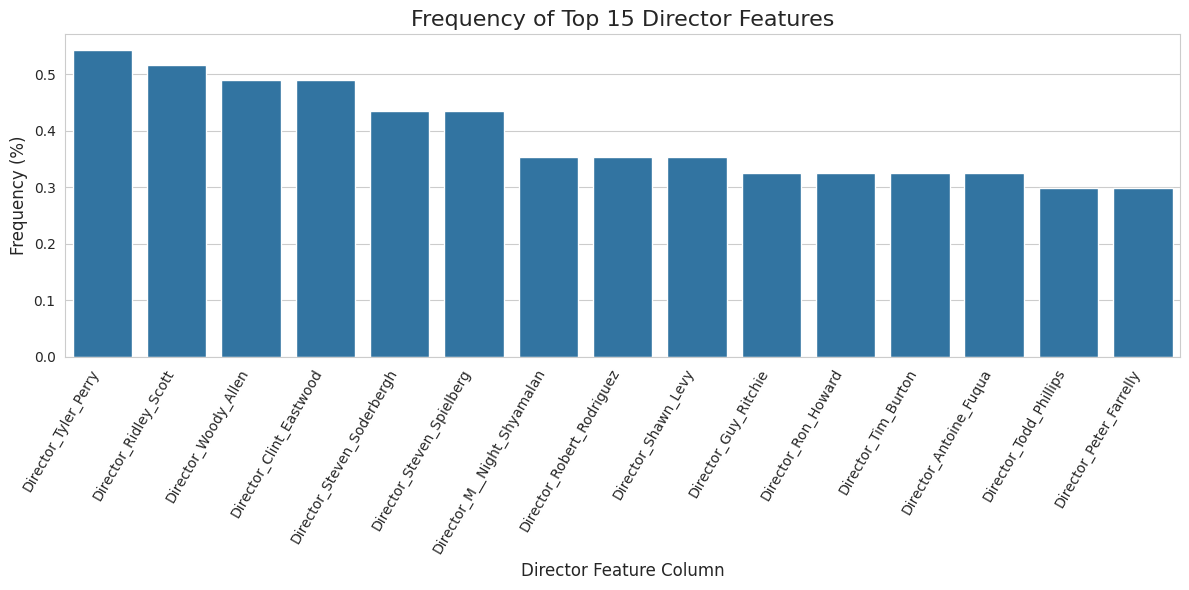


Top 15 Most Frequent Screenwriter Features:
Screenwriter_Woody_Allen              0.49
Screenwriter_Luc_Besson               0.46
Screenwriter_Tyler_Perry              0.43
Screenwriter_David_Koepp              0.38
Screenwriter_Nicholas_Stoller         0.35
Screenwriter_M__Night_Shyamalan       0.35
Screenwriter_John_Logan               0.33
Screenwriter_Joel_Coen                0.33
Screenwriter_Guillermo_del_Toro       0.33
Screenwriter_Chris_Morgan             0.33
Screenwriter_Ethan_Coen               0.30
Screenwriter_Tony_Gilroy              0.30
Screenwriter_Brian_Helgeland          0.30
Screenwriter_Akiva_Goldsman           0.30
Screenwriter_Christopher_McQuarrie    0.30
dtype: float64


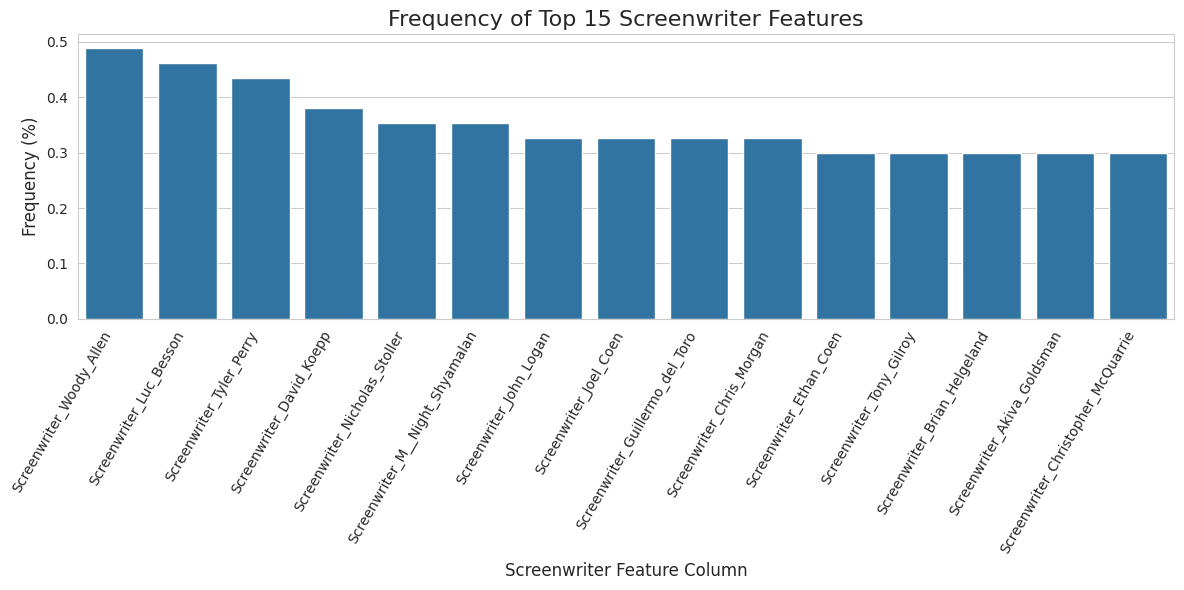


Analyzing Frequency of Top Roles...
Top 15 Most Frequent Roles (based on 3681 movies with credits):
Director                    97.77
Screenwriter                87.99
Producer                    74.87
Composer                    67.92
Executive Producer          65.91
Editor                      63.14
Production Designer         56.81
Costume Designer            49.63
Director of Photography     44.50
Casting Director            42.73
Art Director                38.98
Set Decorator               36.81
Supervising Sound Editor    35.29
Re-recording Mixer          35.23
Sound Mixer                 32.06
dtype: float64


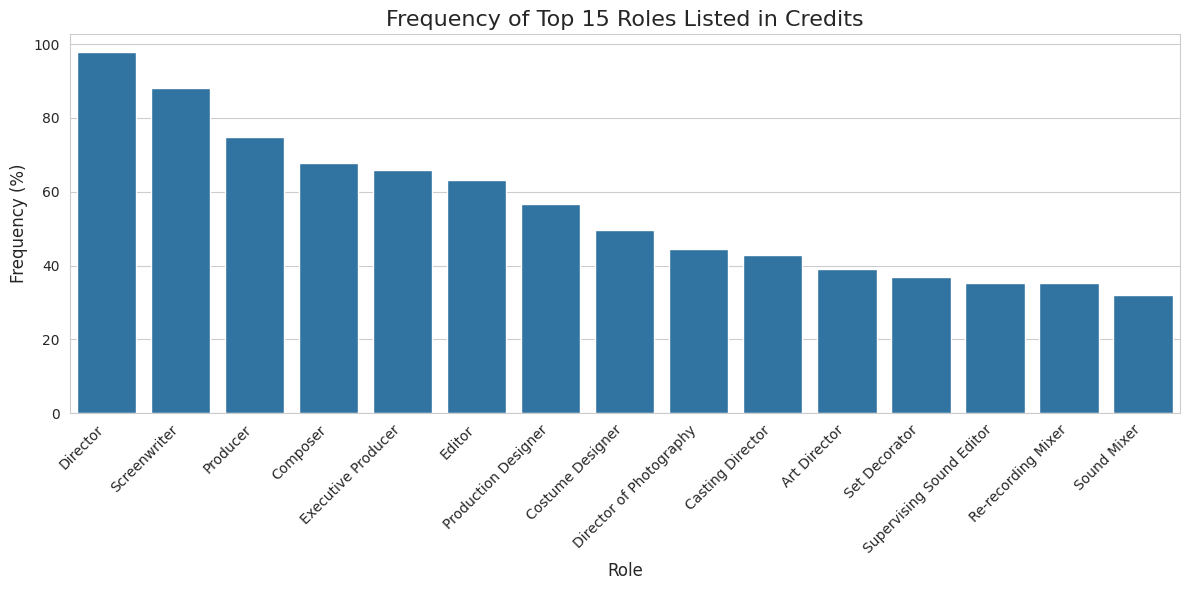


Calculating Unique Entity Counts...
Total number of unique actors found: 2900

Number of unique workers found per role (Top 30):
Executive Producer           4048
Producer                     3153
Screenwriter                 3140
Director                     1835
Co-Producer                  1359
Art Director                 1284
Associate Producer           1054
Editor                       1015
Story Creator                 950
Production Designer           770
Set Designer                  702
Visual Effects Supervisor     678
Composer                      665
Sound Effects Editor          661
Set Decorator                 624
Director of Photography       615
Costume Designer              595
Unit Production Manager       592
Hairstylist                   559
Make up                       556
Stunt Coordinator             552
Assistant Director            534
Sound Mixer                   498
Casting Director              497
Dialogue Editor               496
Costume Supervisor  

In [ ]:
# ==============================================================================
# --- 5. Frequency and Unique Count Analysis ---
# ==============================================================================
print("\n--- 5. Frequency and Unique Count Analysis ---")
num_movies = len(df_final_with_synopsis)

# --- 5.1 Frequency of Top N Features ---
print("\nAnalyzing Frequency of Top N Features...")
feature_categories = {
    "Actor": "actor_",
    "Company": "company_",
    # Add specific roles if desired, using role_prefixes from above
    role_prefixes[0].strip("_"): role_prefixes[0] if len(role_prefixes) > 0 else "",
    role_prefixes[1].strip("_"): role_prefixes[1] if len(role_prefixes) > 1 else "",
}

for category_name, prefix in feature_categories.items():
    if not prefix:
        continue  # Skip if prefix is empty
    cols = [col for col in df_final_with_synopsis.columns if col.startswith(prefix)]
    if not cols:
        print(
            f"No columns found for prefix '{prefix}'. Skipping frequency analysis for {category_name}."
        )
        continue

    freq = (
        df_final_with_synopsis[cols].sum().sort_values(ascending=False)
        / num_movies
        * 100
    )
    print(f"\nTop {VIS_TOP_N} Most Frequent {category_name} Features:")
    print(freq.head(VIS_TOP_N).round(2))
    plt.figure(figsize=(12, 6))
    sns.barplot(x=freq.head(VIS_TOP_N).index, y=freq.head(VIS_TOP_N).values)
    plt.title(f"Frequency of Top {VIS_TOP_N} {category_name} Features")
    plt.ylabel("Frequency (%)")
    plt.xlabel(f"{category_name} Feature Column")
    plt.xticks(rotation=60, ha="right")
    plt.tight_layout()
    plt.show()

# --- 5.2 Frequency of Top Roles (using original data) ---
print("\nAnalyzing Frequency of Top Roles...")
if (
    "parsed_credits_data" in df_aligned.columns
    and not df_aligned["parsed_credits_data"].isnull().all()
):
    all_roles_counter = Counter()  # Recalculate from valid data
    parsed_credits_valid_freq = df_aligned["parsed_credits_data"].dropna()
    num_valid_credits = len(parsed_credits_valid_freq)
    parsed_credits_valid_freq.apply(
        lambda cred_dict: all_roles_counter.update(
            list(cred_dict.keys()) if isinstance(cred_dict, dict) else []
        )
    )

    if all_roles_counter and num_valid_credits > 0:
        role_counts = pd.Series(all_roles_counter).sort_values(ascending=False)
        role_freq = role_counts / num_valid_credits * 100
        print(
            f"Top {VIS_TOP_N} Most Frequent Roles (based on {num_valid_credits} movies with credits):"
        )
        print(role_freq.head(VIS_TOP_N).round(2))
        plt.figure(figsize=(12, 6))
        sns.barplot(
            x=role_freq.head(VIS_TOP_N).index, y=role_freq.head(VIS_TOP_N).values
        )
        plt.title(f"Frequency of Top {VIS_TOP_N} Roles Listed in Credits")
        plt.ylabel("Frequency (%)")
        plt.xlabel("Role")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
    else:
        print("Could not calculate role frequencies.")
else:
    print("Skipping role frequency analysis, parsed credits missing.")


# --- 5.3 Unique Entity Counts ---
print("\nCalculating Unique Entity Counts...")
# Actors
if (
    "parsed_actors_data" in df_aligned.columns
    and not df_aligned["parsed_actors_data"].isnull().all()
):
    all_unique_actors_set = set()
    for list_of_dicts in df_aligned["parsed_actors_data"].dropna():
        if isinstance(list_of_dicts, list):
            for actor_dict in list_of_dicts:
                if isinstance(actor_dict, dict) and "actor" in actor_dict:
                    actor_name = actor_dict.get("actor")
                    if isinstance(actor_name, str):
                        cleaned_name = actor_name.strip()
                        if cleaned_name:
                            all_unique_actors_set.add(cleaned_name)
    print(f"Total number of unique actors found: {len(all_unique_actors_set)}")
else:
    print("Could not count unique actors.")

# Workers per Role
if (
    "parsed_credits_data" in df_aligned.columns
    and not df_aligned["parsed_credits_data"].isnull().all()
):
    role_unique_workers = defaultdict(set)
    valid_credits_unique = df_aligned["parsed_credits_data"].dropna()
    for credit_dict in valid_credits_unique:
        if isinstance(credit_dict, dict):
            for role, people_list in credit_dict.items():
                role_cleaned = str(role).strip()
                if not role_cleaned:
                    continue
                if isinstance(people_list, list):
                    for person in people_list:
                        person_cleaned = str(person).strip()
                        if person_cleaned:
                            role_unique_workers[role_cleaned].add(person_cleaned)
    if role_unique_workers:
        role_unique_counts = {
            role: len(workers) for role, workers in role_unique_workers.items()
        }
        role_counts_series = pd.Series(role_unique_counts).sort_values(ascending=False)
        print("\nNumber of unique workers found per role (Top 30):")
        print(role_counts_series.head(30))
    else:
        print("Could not count unique workers per role.")
else:
    print("Could not count unique workers per role, parsed credits missing.")


# Final Preparation for Modeling

The final step before modeling is to ensure our dataset is ready. We verify that:
1. All features are clean and properly formatted.
2. There are no missing values in the dataset.
3. The dataset contains all the necessary features for modeling.

At the end of this step, we have a fully processed DataFrame (`df_final_with_synopsis`) that is ready for machine learning.

In [ ]:
# ==============================================================================
# --- 6. Final Preparation for Modeling ---
# ==============================================================================
print("\n--- 6. Final Preparation for Modeling ---")

# The DataFrame 'df_final_with_synopsis' is now ready.
# It contains numerical features, OHE features, Top-N/Role-Person features, and TF-IDF features.

# Display final shape and info
print(
    f"\nFinal DataFrame for modeling ('df_final_with_synopsis') shape: {df_final_with_synopsis.shape}"
)
print("Final DataFrame Info Snippet:")
df_final_with_synopsis.info(verbose=False, max_cols=10)  # Show brief info

# Verify no remaining NaNs (should have been handled)
print(
    f"\nTotal NaN values in final DataFrame: {df_final_with_synopsis.isnull().sum().sum()}"
)


print("\n--- Full Script Complete ---")
print("DataFrame 'df_final_with_synopsis' is ready for modeling steps.")

# Outlier Detection and Removal

In this section, we focus on identifying and removing outliers from our dataset. Outliers can significantly skew our model's performance, especially when predicting numerical values like `opening_weekend`. 

We use the Interquartile Range (IQR) method to detect outliers in the log-transformed target variable (`opening_weekend_log`). The IQR method is robust and helps us identify extreme values that fall outside the typical range of the data.

After identifying the outliers, we filter them out to create a cleaner dataset (`df_filtered`) for modeling. This step ensures that our model is trained on data that represents the majority of the distribution, improving its generalization ability.

In [ ]:
import pandas as pd
import numpy as np
import time
import re
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso  # Keep CPU versions for comparison

# Import GPU-enabled libraries
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


print(f"Original shape before outlier removal: {df_final_with_synopsis.shape}")

# --- 1. Outlier Detection and Removal ---
print("\n--- 1. Detecting and Removing Outliers based on opening_weekend_log ---")

TARGET_LOG = "opening_weekend_log"

if TARGET_LOG not in df_final_with_synopsis.columns:
    print(f"Error: Target column '{TARGET_LOG}' not found for outlier detection.")
    # Handle error - maybe calculate log target if missing
    if "opening_weekend" in df_final_with_synopsis.columns:
        df_final_with_synopsis[TARGET_LOG] = np.log1p(
            df_final_with_synopsis["opening_weekend"]
        )
        print(f"Calculated '{TARGET_LOG}'.")
    else:
        print("Cannot proceed without target variable.")
        exit()


# Calculate IQR for the log-transformed target
Q1 = df_final_with_synopsis[TARGET_LOG].quantile(0.25)
Q3 = df_final_with_synopsis[TARGET_LOG].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1
upper_bound = Q3

print(f"Outlier Detection using IQR for '{TARGET_LOG}':")
print(f"  Q1: {Q1:.4f}")
print(f"  Q3: {Q3:.4f}")
print(f"  IQR: {IQR:.4f}")
print(f"  Lower Bound: {lower_bound:.4f}")
print(f"  Upper Bound: {upper_bound:.4f}")

# Identify outliers
outliers_mask = (df_final_with_synopsis[TARGET_LOG] < lower_bound) | (
    df_final_with_synopsis[TARGET_LOG] > upper_bound
)
num_outliers = outliers_mask.sum()
print(f"\nIdentified {num_outliers} outliers based on '{TARGET_LOG}'.")

# Filter the DataFrame
df_filtered = df_final_with_synopsis[
    ~outliers_mask
].copy()  # Keep rows *not* marked as outliers
print(f"Shape after removing outliers: {df_filtered.shape}")

# --- Optional: Filter df_aligned as well if needed later ---
if "df_aligned" in locals() or "df_aligned" in globals():
    if df_aligned.index.equals(
        df_final_with_synopsis.index
    ):  # Check if index was preserved
        df_aligned_filtered = df_aligned.loc[df_filtered.index].copy()
        print(f"Filtered df_aligned shape: {df_aligned_filtered.shape}")
    else:
        print(
            "Warning: Index mismatch between df_aligned and df_final_with_synopsis. Cannot filter df_aligned reliably."
        )
        df_aligned_filtered = None  # Indicate it's not filtered
else:
    df_aligned_filtered = None

# --- 2. Prepare Data for Modeling (using filtered data) ---
print("\n--- 2. Preparing Data for Modeling (using filtered data) ---")
# Use df_filtered from now on

TARGET_ORIGINAL = "opening_weekend"  # Still need original for evaluation metrics

try:
    # Ensure target columns exist in df_filtered
    if (
        TARGET_LOG not in df_filtered.columns
        or TARGET_ORIGINAL not in df_filtered.columns
    ):
        raise KeyError("Target columns missing after filtering.")

    X = df_filtered.drop([TARGET_LOG, TARGET_ORIGINAL], axis=1)
    y = df_filtered[TARGET_LOG]
    y_original = df_filtered[
        TARGET_ORIGINAL
    ]  # Original scale target from filtered data

    # --- Sanitize feature names (important for XGBoost/LGBM) ---
    print("Sanitizing feature names...")
    original_columns = X.columns
    X.columns = [re.sub(r'[\[\]{}:",]', "_", col) for col in X.columns]
    changed_cols_count = sum(
        1 for oc, nc in zip(original_columns, X.columns) if oc != nc
    )
    print(f"Sanitized {changed_cols_count} column names.")
    # --- End Sanitization ---

    print(f"Features shape (filtered): {X.shape}")
    print(f"Target shape (filtered): {y.shape}")

except KeyError as e:
    print(f"Error separating features/target after filtering: Missing column {e}")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during data preparation after filtering: {e}")
    exit()

# Split filtered data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# Get corresponding original scale target values for test set evaluation
y_test_original = y_original.loc[y_test.index]  # Get original values using test index

print(f"Training set shape (filtered): X={X_train.shape}, y={y_train.shape}")
print(f"Testing set shape (filtered): X={X_test.shape}, y={y_test.shape}")

# ==============================================================================
# --- 3. Model Training and Evaluation (Example using XGBoost) ---
# ==============================================================================
print("\n--- 3. Training and Evaluating Models (Example: XGBoost on Filtered Data) ---")
# You would now plug X_train, y_train, X_test, y_test into your
# preferred model training script (e.g., the previous XGBoost/LightGBM/NN scripts)

# --- Example using XGBoost Pipeline ---
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)


# --- Define MdAPE function ---
def median_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    epsilon = 1e-8
    valid_idx = np.where(np.abs(y_true) > epsilon)[0]
    if len(valid_idx) == 0:
        return np.nan
    y_true_filt = y_true[valid_idx]
    y_pred_filt = y_pred[valid_idx]
    return np.median(np.abs((y_true_filt - y_pred_filt) / y_true_filt)) * 100


pipe_xgb = Pipeline(
    [
        (
            "model",
            xgb.XGBRegressor(
                objective="reg:squarederror",
                device="cuda",
                tree_method="hist",
                n_estimators=300,  # Use previously found good params or re-tune
                learning_rate=0.05,
                max_depth=5,
                subsample=0.8,  # Example: Add if used before
                colsample_bytree=0.7,  # Example: Add if used before
                random_state=42,
            ),
        )
    ]
)

print("\nTraining XGBoost on filtered data...")
start_time = time.time()
pipe_xgb.fit(X_train, y_train)
end_time = time.time()
print(f"Training finished in {end_time - start_time:.2f} seconds.")

print("\nEvaluating XGBoost on filtered test set...")
y_pred_log = pipe_xgb.predict(X_test)

# --- Metrics on Log Scale ---
r2_log = r2_score(y_test, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
mae_log = mean_absolute_error(y_test, y_pred_log)
print(f"Test Set Performance (XGBoost - Log Scale - Filtered Data):")
print(f"  R-squared: {r2_log:.4f}")
print(f"  RMSE:      {rmse_log:.4f}")
print(f"  MAE:       {mae_log:.4f}")

# --- Metrics on Original Scale (Absolute & Relative) ---
y_pred_original = np.expm1(y_pred_log)
y_pred_original[y_pred_original < 0] = 0
y_test_original_np = y_test_original.values  # Use the saved original scale test targets

r2_orig = r2_score(y_test_original_np, y_pred_original)
rmse_orig = np.sqrt(mean_squared_error(y_test_original_np, y_pred_original))
mae_orig = mean_absolute_error(y_test_original_np, y_pred_original)
print(f"Test Set Performance (XGBoost - Original Scale - Absolute - Filtered Data):")
print(f"  R-squared: {r2_orig:.4f}")
print(f"  RMSE:      ${rmse_orig:,.0f}")
print(f"  MAE:       ${mae_orig:,.0f}")

valid_perc_error_idx = np.where(np.abs(y_test_original_np) > 100)[0]
print(
    f"  Calculating percentage errors using {len(valid_perc_error_idx)} samples where abs(actual) > 100."
)
if len(valid_perc_error_idx) > 0:
    y_test_filt = y_test_original_np[valid_perc_error_idx]
    y_pred_filt = y_pred_original[valid_perc_error_idx]
    y_pred_filt = np.nan_to_num(
        y_pred_filt, nan=0.0, posinf=y_test_filt.max() * 10, neginf=0.0
    )
    mape_orig = mean_absolute_percentage_error(y_test_filt, y_pred_filt) * 100
    mdape_orig = median_absolute_percentage_error(y_test_filt, y_pred_filt)
else:
    mape_orig, mdape_orig = np.nan, np.nan
print(f"Test Set Performance (XGBoost - Original Scale - Relative - Filtered Data):")
print(f"  MAPE:      {mape_orig:.2f}%")
print(f"  MdAPE:     {mdape_orig:.2f}%")

print("\n--- Outlier Removal and Retraining Example Complete ---")

Original shape before outlier removal: (3681, 2271)

--- 1. Detecting and Removing Outliers based on opening_weekend_log ---
Outlier Detection using IQR for 'opening_weekend_log':
  Q1: 14.5850
  Q3: 16.8885
  IQR: 2.3036
  Lower Bound: 14.5850
  Upper Bound: 16.8885

Identified 1840 outliers based on 'opening_weekend_log'.
Shape after removing outliers: (1841, 2271)
Filtered df_aligned shape: (1841, 21)

--- 2. Preparing Data for Modeling (using filtered data) ---
Sanitizing feature names...
Sanitized 305 column names.
Features shape (filtered): (1841, 2269)
Target shape (filtered): (1841,)
Training set shape (filtered): X=(1472, 2269), y=(1472,)
Testing set shape (filtered): X=(369, 2269), y=(369,)

--- 3. Training and Evaluating Models (Example: XGBoost on Filtered Data) ---

Training XGBoost on filtered data...
Training finished in 5.14 seconds.

Evaluating XGBoost on filtered test set...
Test Set Performance (XGBoost - Log Scale - Filtered Data):
  R-squared: 0.1482
  RMSE:      0

# Clustering for Enhanced Modeling

Here, we explore clustering as a way to enhance our modeling process. The idea is to group movies into clusters based on their features, such as production budget, runtime, and release year. By doing so, we can train separate models for each cluster, allowing us to capture unique patterns within each group.

We start by selecting relevant features for clustering and scaling them using `StandardScaler`. Scaling ensures that all features contribute equally to the clustering process, regardless of their original scale.

Next, we determine the optimal number of clusters (`K`) and perform clustering using the K-Means algorithm. Each movie is assigned a cluster label, which we add as a new feature to our dataset. This clustering step allows us to tailor our models to the specific characteristics of each group.

In [ ]:
import pandas as pd
import numpy as np
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns
import copy  # For deep copying models if needed, though state_dict is better

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    KFold,
)  # Use KFold for inner CV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline

# --- Regression Models ---
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# from lightgbm import LGBMRegressor # Add if desired and working
# --- Metrics ---
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)


# --- Define MdAPE function ---
def median_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    epsilon = 1e-8
    valid_idx = np.where(np.abs(y_true) > epsilon)[0]
    if len(valid_idx) == 0:
        return np.nan
    y_true_filt = y_true[valid_idx]
    y_pred_filt = y_pred[valid_idx]
    # Ensure y_pred_filt aligns if some NaNs were introduced earlier
    valid_pred_idx = np.where(~np.isnan(y_pred_filt))[0]
    y_true_filt = y_true_filt[valid_pred_idx]
    y_pred_filt = y_pred_filt[valid_pred_idx]
    if len(y_true_filt) == 0:
        return np.nan
    return np.median(np.abs((y_true_filt - y_pred_filt) / y_true_filt)) * 100


# --- 1. Load Data & Prepare Base Features ---
print("--- 1. Load Data & Prepare Base Features ---")
# Assume 'df_filtered' exists
TARGET = "opening_weekend_log"
TARGET_ORIGINAL = "opening_weekend"
if TARGET not in df_filtered.columns or TARGET_ORIGINAL not in df_filtered.columns:
    print("Error: Target columns missing!")
    exit()
X_full_orig = df_filtered.drop([TARGET, TARGET_ORIGINAL], axis=1)
y_full = df_filtered[TARGET]
y_original_full = df_filtered[TARGET_ORIGINAL]
# Sanitize feature names early
print("Sanitizing feature names...")
X_full = X_full_orig.copy()  # Work on a copy for renaming
original_columns = X_full.columns
X_full.columns = [re.sub(r'[\[\]{}:",]', "_", col) for col in X_full.columns]
changed_cols_count = sum(
    1 for oc, nc in zip(original_columns, X_full.columns) if oc != nc
)
print(f"Sanitized {changed_cols_count} column names.")
print(f"Full features shape: {X_full.shape}")


# --- 2. Feature Selection and Scaling for Clustering ---
print("\n--- 2. Feature Selection and Scaling for Clustering ---")
cols_for_clustering = [
    "production_budget_cleaned",
    "running_time_cleaned",
    "keywords_count",
    "num_financing_companies",
    "num_lead_actors",
    "num_technical_roles",
    "num_directors",
    "release_year",
]
cols_for_clustering = [
    col for col in cols_for_clustering if col in X_full.columns
]  # Ensure columns exist after potential sanitization
if not cols_for_clustering:
    print("Error: No suitable columns found for clustering!")
    exit()
print(f"Using columns for clustering: {cols_for_clustering}")
X_cluster_features = X_full[cols_for_clustering].copy()
for col in X_cluster_features.columns:  # Impute missing
    if X_cluster_features[col].isnull().any():
        median_val = X_cluster_features[col].median()
        X_cluster_features[col].fillna(median_val, inplace=True)
cluster_scaler = StandardScaler()
X_clust_scaled = cluster_scaler.fit_transform(X_cluster_features)
print("Features for clustering scaled.")


# --- 3. Determine Optimal K & Perform Clustering ---
print("\n--- 3. Determining K and Performing Clustering ---")
# (Optional: Add back the Elbow/Silhouette plotting code if you want to re-run it)
OPTIMAL_K = 4  # *** Replace with K chosen from your previous analysis ***
print(f"Using predefined K = {OPTIMAL_K} for clustering.")
kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_clust_scaled)
X_full["Cluster"] = cluster_labels  # Add cluster label to the *full* feature set
print("Cluster labels added to main feature DataFrame 'X_full'.")
print("Cluster sizes:\n", X_full["Cluster"].value_counts().sort_index())


# --- 4. Train/Test Split ---
print("\n--- 4. Splitting Data into Train/Test Sets ---")
X_train, X_test, y_train, y_test = train_test_split(
    X_full,
    y_full,
    test_size=0.2,
    random_state=42,  # Cannot easily stratify by cluster AND target
)
y_train_original = y_original_full.loc[y_train.index]
y_test_original = y_original_full.loc[y_test.index]
print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")


# --- 5. Define Candidate Models and Grids for Per-Cluster Selection ---
print("\n--- 5. Defining Candidate Models and Grids ---")
candidate_pipelines = {}
candidate_param_grids = {}

# -- Ridge --
pipe_ridge = Pipeline([("scaler", StandardScaler()), ("model", Ridge(random_state=42))])
candidate_pipelines["Ridge"] = pipe_ridge
candidate_param_grids["Ridge"] = {"model__alpha": [10.0, 100.0, 500.0, 1000.0]}

# -- RandomForest --
pipe_rf = Pipeline([("model", RandomForestRegressor(random_state=42, n_jobs=-1))])
candidate_pipelines["RandomForest"] = pipe_rf
candidate_param_grids["RandomForest"] = {
    "model__n_estimators": [100, 250],
    "model__max_depth": [15, 25, None],
    "model__min_samples_leaf": [5, 10],
    "model__max_features": ["sqrt", 0.5],
}

# -- XGBoost --
pipe_xgb = Pipeline(
    [
        (
            "model",
            xgb.XGBRegressor(
                objective="reg:squarederror",
                device="cuda",
                tree_method="hist",
                random_state=42,
                subsample=0.8,
                colsample_bytree=0.7,
            ),
        )
    ]
)
candidate_pipelines["XGBoost"] = pipe_xgb
candidate_param_grids["XGBoost"] = {
    "model__n_estimators": [100, 300],
    "model__learning_rate": [0.1, 0.05],
    "model__max_depth": [6, 8],
}
# Combine grids for GridSearchCV - it needs a list of dictionaries
param_grid_list = [
    {**{"model": [pipe_ridge]}, **candidate_param_grids["Ridge"]},
    {**{"model": [pipe_rf]}, **candidate_param_grids["RandomForest"]},
    {**{"model": [pipe_xgb]}, **candidate_param_grids["XGBoost"]},
]
# A simpler way if only tuning params *within* each model type:
# Define search space per model type, then run GridSearchCV for each type
# For simplicity here, we'll iterate through models and grids explicitly


# --- 6. Per-Cluster Model Selection and Training ---
print("\n--- 6. Per-Cluster Model Selection and Training ---")

best_cluster_models = {}  # Store the best fitted pipeline for each cluster
cluster_selection_results = {}  # Store info about the selection process

# Use KFold for inner cross-validation within GridSearchCV
# Stratification isn't directly applicable here as we subset data first
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

unique_clusters_train = sorted(X_train["Cluster"].unique())
print(f"Selecting and training models for clusters: {unique_clusters_train}")

MIN_SAMPLES_FOR_CV = 10  # Need enough samples for inner CV splits

for cluster_id in unique_clusters_train:
    print(f"\n===== Processing Cluster {cluster_id} =====")

    # Filter training data for the current cluster
    X_train_cluster = X_train[X_train["Cluster"] == cluster_id].drop("Cluster", axis=1)
    y_train_cluster = y_train[X_train["Cluster"] == cluster_id]
    num_train_cluster = len(X_train_cluster)

    if num_train_cluster < MIN_SAMPLES_FOR_CV:
        print(
            f"Skipping Cluster {cluster_id}: Insufficient training samples ({num_train_cluster}) for reliable CV."
        )
        best_cluster_models[cluster_id] = None  # Mark as no model trained
        cluster_selection_results[cluster_id] = {
            "n_train_samples": num_train_cluster,
            "Best Model": "N/A (Skipped)",
            "Best Params": {},
            "Best CV Score (neg_RMSE)": np.nan,
        }
        continue

    print(f"Cluster {cluster_id}: Training samples = {num_train_cluster}")
    print(f"Searching best model among: {list(candidate_pipelines.keys())}")

    best_score_for_cluster = -float(
        "inf"
    )  # Maximize neg_root_mean_squared_error (closer to 0)
    best_estimator_for_cluster = None
    best_model_name_for_cluster = None
    best_params_for_cluster = None

    # Iterate through each candidate model type
    for model_name, pipe in candidate_pipelines.items():
        print(f"  -- Tuning {model_name} for Cluster {cluster_id} --")
        param_grid = candidate_param_grids[model_name]

        # Set n_jobs based on model type
        n_jobs_cv_inner = 1 if "XGBoost" in model_name else -1  # Example heuristic

        # Use GridSearchCV to find best params *for this model type* on this cluster's data
        grid_search = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            scoring="neg_root_mean_squared_error",
            cv=inner_cv,
            n_jobs=n_jobs_cv_inner,
            verbose=0,  # Keep inner loop less verbose
        )

        try:
            grid_search.fit(X_train_cluster, y_train_cluster)

            # Check if this model type is better than the current best for this cluster
            if grid_search.best_score_ > best_score_for_cluster:
                best_score_for_cluster = grid_search.best_score_
                best_estimator_for_cluster = (
                    grid_search.best_estimator_
                )  # Store the best pipeline
                best_model_name_for_cluster = model_name
                best_params_for_cluster = grid_search.best_params_
                print(
                    f"    New best score for cluster {cluster_id}: {best_score_for_cluster:.4f} (neg_RMSE) with {model_name}"
                )

        except Exception as e:
            print(
                f"    !!! Failed tuning {model_name} for cluster {cluster_id}. Error: {e} !!!"
            )

    # Store the overall best model/pipeline found for this cluster
    best_cluster_models[cluster_id] = best_estimator_for_cluster
    cluster_selection_results[cluster_id] = {
        "n_train_samples": num_train_cluster,
        "Best Model": best_model_name_for_cluster,
        "Best Params": best_params_for_cluster,
        "Best CV Score (neg_RMSE)": best_score_for_cluster,
    }
    if best_estimator_for_cluster:
        print(
            f"-> Cluster {cluster_id}: Best model selected: {best_model_name_for_cluster} (CV neg_RMSE: {best_score_for_cluster:.4f})"
        )
    else:
        print(f"-> Cluster {cluster_id}: No model successfully trained.")


# --- 7. Overall Evaluation on Full Test Set ---
print("\n--- 7. Evaluating Overall Performance on Full Test Set ---")
# (Evaluation loop and metric calculation remain the same as the previous script,
#  using best_cluster_models to get the specific pipeline for each test sample's cluster)
# ... [Paste Section 7 from previous script here] ...

all_preds_log = []
all_true_log = []
all_true_original = []
processed_indices = []

# Iterate through the full test set
for index, row in X_test.iterrows():
    cluster_id = int(row["Cluster"])
    best_pipeline = best_cluster_models.get(cluster_id)  # Get the best pipeline

    # Prepare the sample (remove cluster ID) - ensure it's 2D for predict
    # Need to use original column names before sanitization if model wasn't trained on sanitized names,
    # BUT gridsearch used sanitized names from X_train_cluster, so use sanitized names here too.
    sample_features = row.drop("Cluster").values.reshape(1, -1)

    pred_log = np.nan  # Default

    if best_pipeline is not None:
        try:
            pred_log = best_pipeline.predict(sample_features)[0]
        except Exception as pred_e:
            print(
                f"Warning: Prediction failed for cluster {cluster_id}, sample {index}. Error: {pred_e}"
            )
            pred_log = y_train.mean()  # Fallback
    else:
        # Fallback strategy: Use overall training mean log value
        pred_log = y_train.mean()
        # print(f"Warning: No model found for cluster {cluster_id} (sample index {index}). Using overall mean {pred_log:.4f}.")

    all_preds_log.append(pred_log)
    all_true_log.append(y_test.loc[index])
    all_true_original.append(y_test_original.loc[index])
    processed_indices.append(index)

# Convert lists to arrays
y_pred_log_overall = np.array(all_preds_log)
y_test_log_overall = np.array(all_true_log)
y_test_original_overall = np.array(all_true_original)

# Handle potential NaNs
valid_preds_mask = ~np.isnan(y_pred_log_overall)
if not np.all(valid_preds_mask):
    num_nan = np.sum(~valid_preds_mask)
    print(
        f"Warning: Evaluating on {valid_preds_mask.sum()} out of {len(y_pred_log_overall)} test samples due to {num_nan} NaN predictions."
    )
    y_pred_log_overall = y_pred_log_overall[valid_preds_mask]
    y_test_log_overall = y_test_log_overall[valid_preds_mask]
    y_test_original_overall = y_test_original_overall[valid_preds_mask]


# --- Calculate Overall Metrics ---
print("\n--- Overall Test Set Performance (Using Best Model per Cluster) ---")
if len(y_test_log_overall) > 0:
    # Log Scale
    r2_log = r2_score(y_test_log_overall, y_pred_log_overall)
    rmse_log = np.sqrt(mean_squared_error(y_test_log_overall, y_pred_log_overall))
    mae_log = mean_absolute_error(y_test_log_overall, y_pred_log_overall)
    print(
        f"Overall Performance (Log Scale): R2={r2_log:.4f}, RMSE={rmse_log:.4f}, MAE={mae_log:.4f}"
    )
    # Original Scale
    y_pred_original_overall = np.expm1(y_pred_log_overall)
    y_pred_original_overall[y_pred_original_overall < 0] = 0
    r2_orig = r2_score(y_test_original_overall, y_pred_original_overall)
    rmse_orig = np.sqrt(
        mean_squared_error(y_test_original_overall, y_pred_original_overall)
    )
    mae_orig = mean_absolute_error(y_test_original_overall, y_pred_original_overall)
    print(
        f"Overall Performance (Original Scale - Absolute): R2={r2_orig:.4f}, RMSE=${rmse_orig:,.0f}, MAE=${mae_orig:,.0f}"
    )
    valid_perc_error_idx = np.where(np.abs(y_test_original_overall) > 100)[0]
    print(
        f"  Calculating percentage errors using {len(valid_perc_error_idx)} samples where abs(actual) > 100."
    )
    if len(valid_perc_error_idx) > 0:
        y_test_filt = y_test_original_overall[valid_perc_error_idx]
        y_pred_filt = y_pred_original_overall[valid_perc_error_idx]
        y_pred_filt = np.nan_to_num(
            y_pred_filt, nan=0.0, posinf=np.percentile(y_test_filt, 99) * 2, neginf=0.0
        )
        mape_orig = mean_absolute_percentage_error(y_test_filt, y_pred_filt) * 100
        mdape_orig = median_absolute_percentage_error(y_test_filt, y_pred_filt)
    else:
        mape_orig, mdape_orig = np.nan, np.nan
    print(
        f"Overall Performance (Original Scale - Relative): MAPE={mape_orig:.2f}%, MdAPE={mdape_orig:.2f}%"
    )
else:
    print("No valid predictions were generated.")


# --- 8. Display Per-Cluster Model Selection Results ---
print("\n--- 8. Per-Cluster Model Selection Summary ---")
cluster_results_summary_df = pd.DataFrame(cluster_selection_results).T
# Format the score
cluster_results_summary_df["Best CV Score (RMSE)"] = (
    -cluster_results_summary_df["Best CV Score (neg_RMSE)"]
).apply(lambda x: f"{x:.4f}" if pd.notnull(x) else "N/A")
# Select and reorder columns for clarity
display_cols_summary = [
    "n_train_samples",
    "Best Model",
    "Best CV Score (RMSE)",
    "Best Params",
]
cluster_results_summary_df = cluster_results_summary_df[display_cols_summary]
print(cluster_results_summary_df.to_markdown())


print("\n--- Clustering + Per-Cluster Regression Script Complete ---")

--- 1. Load Data & Prepare Base Features ---
Sanitizing feature names...
Sanitized 305 column names.
Full features shape: (1841, 2269)

--- 2. Feature Selection and Scaling for Clustering ---
Using columns for clustering: ['production_budget_cleaned', 'running_time_cleaned', 'keywords_count', 'num_financing_companies', 'num_lead_actors', 'num_technical_roles', 'num_directors', 'release_year']
Features for clustering scaled.

--- 3. Determining K and Performing Clustering ---
Using predefined K = 4 for clustering.
Cluster labels added to main feature DataFrame 'X_full'.
Cluster sizes:
 Cluster
0    837
1    293
2    650
3     61
Name: count, dtype: int64

--- 4. Splitting Data into Train/Test Sets ---
Training set shape: X=(1472, 2270), y=(1472,)
Testing set shape: X=(369, 2270), y=(369,)

--- 5. Defining Candidate Models and Grids ---

--- 6. Per-Cluster Model Selection and Training ---
Selecting and training models for clusters: [np.int32(0), np.int32(1), np.int32(2), np.int32(3)]

==

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/


--- Overall Test Set Performance (Using Best Model per Cluster) ---
Overall Performance (Log Scale): R2=0.0900, RMSE=0.5146, MAE=0.4190
Overall Performance (Original Scale - Absolute): R2=0.0057, RMSE=$5,172,397, MAE=$4,172,935
  Calculating percentage errors using 369 samples where abs(actual) > 100.
Overall Performance (Original Scale - Relative): MAPE=46.63%, MdAPE=33.56%

--- 8. Per-Cluster Model Selection Summary ---
|    |   n_train_samples | Best Model   |   Best CV Score (RMSE) | Best Params                                                                                                       |
|---:|------------------:|:-------------|-----------------------:|:------------------------------------------------------------------------------------------------------------------|
|  0 |               669 | RandomForest |                 0.4832 | {'model__max_depth': 15, 'model__max_features': 0.5, 'model__min_samples_leaf': 10, 'model__n_estimators': 100}   |
|  1 |               226

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


# Model Training and Evaluation

In this section, we train and evaluate multiple machine learning models to predict the `opening_weekend` gross. We use a variety of models, including Ridge Regression, Lasso Regression, Random Forest, XGBoost, and LightGBM. Each model has its strengths, and by comparing their performance, we can identify the best approach for our dataset.

For each model, we define a pipeline that includes preprocessing steps (e.g., scaling) and the model itself. We also specify a parameter grid for hyperparameter tuning using `GridSearchCV`. This ensures that we find the best configuration for each model.

After training, we evaluate the models on both the log-transformed and original scales of the target variable. Metrics such as R-squared, RMSE, MAE, MAPE, and MdAPE are calculated to assess performance. These metrics provide a comprehensive view of how well each model predicts the opening weekend gross.

--- 1. Preparing Data ---
Sanitizing feature names for LightGBM compatibility...
Sanitized 305 column names.
Features shape after sanitization: (1841, 2269)
Target shape: (1841,)
Converted 407 boolean columns to integer.
Training set shape: X=(1472, 2269), y=(1472,)
Testing set shape: X=(369, 2269), y=(369,)

--- 2. Defining Models, Pipelines, and Parameter Grids (GPU enabled - Updated) ---

--- 3. Training and Evaluating Models ---

Training Ridge_CPU...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters for Ridge_CPU: {'model__alpha': 100.0}
Test Set Performance (Ridge_CPU - Log Scale):
  R-squared: -0.9119
  RMSE:      0.7458
  MAE:       0.5969
Test Set Performance (Ridge_CPU - Original Scale - Absolute):
  R-squared: -1.7890
  RMSE:      $8,663,014
  MAE:       $6,468,319
  Calculating percentage errors using 369 non-zero/small test samples.
Test Set Performance (Ridge_CPU - Original Scale - Relative):
  MAPE:      69.56%
  MdAPE:     48.70%
Time taken for 

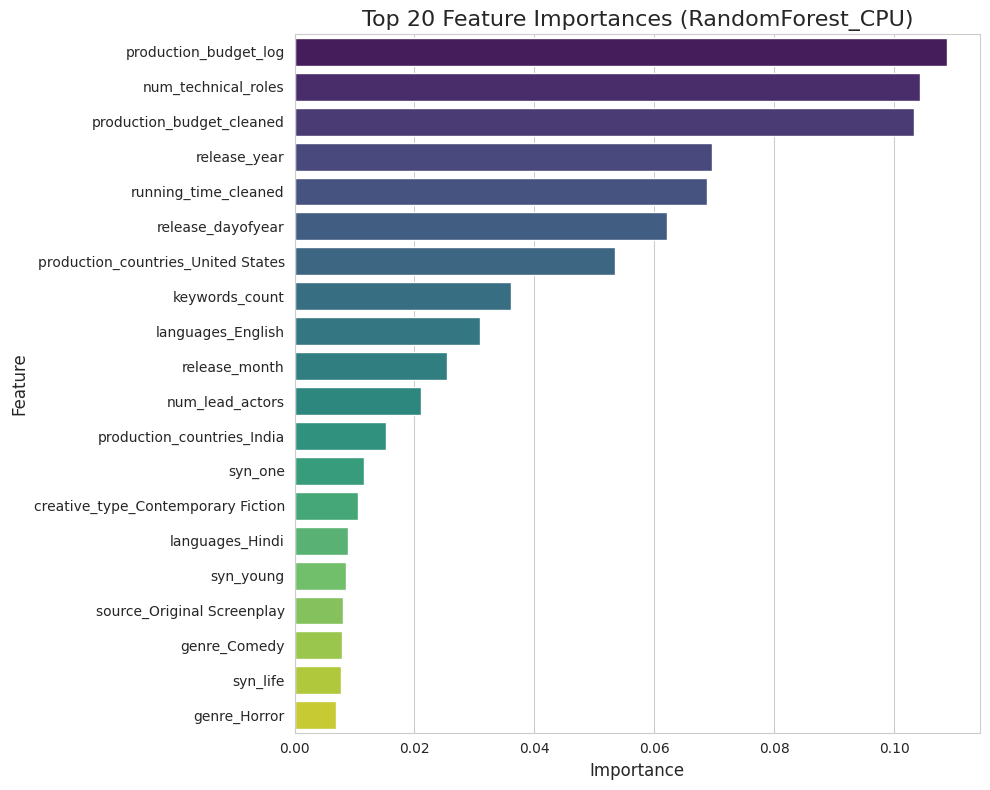


--- Model Comparison Script Complete ---


In [ ]:
import pandas as pd
import numpy as np
import time
import re
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
import xgboost as xgb
import lightgbm as lgb

# Import MAPE metric
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import matplotlib.pyplot as plt
import seaborn as sns


# --- Define MdAPE function ---
def median_absolute_percentage_error(y_true, y_pred):
    """Calculates Median Absolute Percentage Error"""
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    # Ensure non-zero denominator - filter happens before calling this
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100


# --- 1. Prepare Data ---
print("--- 1. Preparing Data ---")
# Assume 'df_filtered' is your fully processed DataFrame

TARGET = "opening_weekend_log"
TARGET_ORIGINAL = "opening_weekend"

try:
    X = df_filtered.drop([TARGET, TARGET_ORIGINAL], axis=1)
    y = df_filtered[TARGET]
    y_original = df_filtered[TARGET_ORIGINAL]

    print("Sanitizing feature names for LightGBM compatibility...")
    original_columns = X.columns
    X.columns = [re.sub(r'[\[\]{}:",]', "_", col) for col in X.columns]
    changed_cols_count = sum(
        1 for oc, nc in zip(original_columns, X.columns) if oc != nc
    )
    print(f"Sanitized {changed_cols_count} column names.")

    print(f"Features shape after sanitization: {X.shape}")
    print(f"Target shape: {y.shape}")
except KeyError as e:
    print(f"Error separating features/target: Missing column {e}")
    exit()
except Exception as e:
    print(f"An unexpected error occurred during data preparation: {e}")
    exit()

# Convert boolean columns to int
bool_cols = X.select_dtypes(include="bool").columns
X[bool_cols] = X[bool_cols].astype("int")
print(f"Converted {len(bool_cols)} boolean columns to integer.")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
y_test_original = y_original.loc[y_test.index]

print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Testing set shape: X={X_test.shape}, y={y_test.shape}")


# --- 2. Define Models, Pipelines, and Parameter Grids (Updated) ---
print(
    "\n--- 2. Defining Models, Pipelines, and Parameter Grids (GPU enabled - Updated) ---"
)
# (Keep the pipeline definitions from the previous step)
pipelines = {}
param_grids = {}

# -- Ridge Regression (CPU - Scikit-learn) --
pipe_ridge = Pipeline([("scaler", StandardScaler()), ("model", Ridge(random_state=42))])
pipelines["Ridge_CPU"] = pipe_ridge
param_grids["Ridge_CPU"] = {"model__alpha": [1.0, 10.0, 100.0]}

# -- Lasso Regression (CPU - Scikit-learn) --
pipe_lasso = Pipeline(
    [("scaler", StandardScaler()), ("model", Lasso(random_state=42, max_iter=3000))]
)
pipelines["Lasso_CPU"] = pipe_lasso
param_grids["Lasso_CPU"] = {"model__alpha": [0.001, 0.01, 0.1]}

# -- XGBoost Regressor (GPU - Updated) --
pipe_xgb = Pipeline(
    [
        (
            "model",
            xgb.XGBRegressor(
                objective="reg:squarederror",
                device="cuda",
                tree_method="hist",
                random_state=42,
                subsample=0.8,
                colsample_bytree=0.7,
            ),
        )
    ]
)
pipelines["XGBoost_GPU"] = pipe_xgb
param_grids["XGBoost_GPU"] = {
    "model__n_estimators": [100, 300],
    "model__learning_rate": [0.1, 0.05],
    "model__max_depth": [6, 8],
}

# -- LightGBM Regressor (CPU) --
pipe_lgb = Pipeline(
    [("model", lgb.LGBMRegressor(objective="regression_l2", random_state=42))]
)
pipelines["LightGBM_CPU"] = pipe_lgb
param_grids["LightGBM_CPU"] = {
    "model__n_estimators": [100, 300],
    "model__learning_rate": [0.1, 0.05],
    "model__num_leaves": [31, 61],
}


# --- *** ADD RANDOM FOREST *** ---
pipe_rf = Pipeline(
    [
        # No scaler needed for Random Forest
        (
            "model",
            RandomForestRegressor(random_state=42, n_jobs=-1),
        )  # Use all CPU cores
    ]
)
pipelines["RandomForest_CPU"] = pipe_rf
param_grids["RandomForest_CPU"] = {
    "model__n_estimators": [150, 300],  # Number of trees
    "model__max_depth": [20, None],  # Max depth (None can be deep)
    "model__min_samples_leaf": [3, 7],  # Min samples per leaf (control complexity)
    "model__max_features": [
        "sqrt",
        0.4,
    ],  # Features to consider at each split ('sqrt' is common, 0.4 is ~40%)
}

# --- 3. Model Training and Evaluation ---
print("\n--- 3. Training and Evaluating Models ---")

results = {}
cv = KFold(n_splits=3, shuffle=True, random_state=42)

for name, pipe in pipelines.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    error_handling = 0  # Default error score

    grid_search = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        scoring="neg_root_mean_squared_error",
        cv=cv,
        n_jobs=-1,
        verbose=1,  # Reduced verbosity slightly
        error_score=error_handling,
    )

    try:
        grid_search.fit(X_train, y_train)

        best_estimator = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Best parameters for {name}: {best_params}")

        y_pred_log = best_estimator.predict(X_test)

        # --- Metrics on Log Scale ---
        r2_log = r2_score(y_test, y_pred_log)
        rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
        mae_log = mean_absolute_error(y_test, y_pred_log)
        print(f"Test Set Performance ({name} - Log Scale):")
        print(f"  R-squared: {r2_log:.4f}")
        print(f"  RMSE:      {rmse_log:.4f}")
        print(f"  MAE:       {mae_log:.4f}")

        # --- Metrics on Original Scale (Absolute) ---
        y_pred_original = np.expm1(y_pred_log)
        y_pred_original[y_pred_original < 0] = 0  # Clip negatives

        r2_orig = r2_score(y_test_original, y_pred_original)
        rmse_orig = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
        mae_orig = mean_absolute_error(y_test_original, y_pred_original)
        print(f"Test Set Performance ({name} - Original Scale - Absolute):")
        print(f"  R-squared: {r2_orig:.4f}")
        print(f"  RMSE:      ${rmse_orig:,.0f}")
        print(f"  MAE:       ${mae_orig:,.0f}")

        # --- *** Metrics on Original Scale (Relative) *** ---
        # Filter out zero/very small actual values for percentage calculation
        # Use a threshold like $1 or $100 depending on the context
        valid_perc_error_idx = y_test_original[abs(y_test_original) > 100].index
        print(
            f"  Calculating percentage errors using {len(valid_perc_error_idx)} non-zero/small test samples."
        )

        if len(valid_perc_error_idx) > 0:
            y_test_filt = y_test_original.loc[valid_perc_error_idx]
            y_pred_filt = pd.Series(y_pred_original, index=y_test_original.index).loc[
                valid_perc_error_idx
            ]  # Ensure alignment

            mape_orig = mean_absolute_percentage_error(y_test_filt, y_pred_filt) * 100
            mdape_orig = median_absolute_percentage_error(
                y_test_filt, y_pred_filt
            )  # Already multiplies by 100
        else:
            print(
                "  Warning: No valid samples found for percentage error calculation (all true values were <= 100)."
            )
            mape_orig = np.nan
            mdape_orig = np.nan

        print(f"Test Set Performance ({name} - Original Scale - Relative):")
        print(f"  MAPE:      {mape_orig:.2f}%")
        print(f"  MdAPE:     {mdape_orig:.2f}%")
        # --- *** End Relative Metrics *** ---

        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Time taken for {name}: {elapsed_time:.2f} seconds")

        results[name] = {
            "Best Params": best_params,
            "R2 (Log)": r2_log,
            "RMSE (Log)": rmse_log,
            "MAE (Log)": mae_log,
            "R2 (Original)": r2_orig,
            "RMSE (Original)": rmse_orig,
            "MAE (Original)": mae_orig,
            "MAPE (Original)": mape_orig,
            "MdAPE (Original)": mdape_orig,  # Add new metrics
            "Time (s)": elapsed_time,
            "Best Estimator": best_estimator,
            "Error": None,
        }

    except Exception as e:
        print(f"!!! Failed to train or evaluate {name}. Error: {e} !!!")
        import traceback

        traceback.print_exc()
        end_time = time.time()
        elapsed_time = end_time - start_time
        results[name] = {
            "Error": str(e),
            "Time (s)": elapsed_time,
            "Best Estimator": None,
        }


# --- 4. Compare Results ---
print("\n--- 4. Comparison of Model Results ---")

results_df = pd.DataFrame(results).T
# Sort by a relative metric now, e.g., MdAPE (lower is better)
results_df = results_df.sort_values(by="MdAPE (Original)", ascending=True)

# Formatting
currency_cols = ["RMSE (Original)", "MAE (Original)"]
for col in currency_cols:
    if col in results_df.columns:
        results_df[col] = results_df[col].apply(
            lambda x: f"${x:,.0f}"
            if pd.notnull(x) and isinstance(x, (int, float))
            else x
            if pd.notnull(x)
            else "N/A"
        )

percentage_cols = ["MAPE (Original)", "MdAPE (Original)"]
for col in percentage_cols:
    if col in results_df.columns:
        results_df[col] = results_df[col].apply(
            lambda x: f"{x:.2f}%"
            if pd.notnull(x) and isinstance(x, (int, float))
            else x
            if pd.notnull(x)
            else "N/A"
        )


# Update display columns
cols_to_display = [
    "MdAPE (Original)",
    "MAPE (Original)",
    "RMSE (Original)",
    "MAE (Original)",
    "R2 (Log)",
    "RMSE (Log)",
    "Time (s)",
    "Best Params",
]
if "Error" in results_df.columns:
    cols_to_display.append("Error")
    results_df_display = results_df[cols_to_display].copy()
    results_df_display["Error"] = results_df_display["Error"].fillna("")
else:
    results_df_display = results_df[cols_to_display].copy()

print(results_df_display.to_markdown())


# --- 5. Optional: Feature Importance (for best model) ---
print("\n--- 5. Feature Importance Analysis ---")
# (Keep the feature importance code from the previous step, it doesn't need changing)
# It will analyze the best model based on the new sorting (MdAPE)
valid_results_df = results_df.dropna(subset=["Best Estimator"])
if not valid_results_df.empty:
    valid_results_df = valid_results_df.sort_values(
        by="MdAPE (Original)", ascending=True
    )  # Ensure sorted by MdAPE
    best_model_name = valid_results_df.index[0]
    best_model_info = valid_results_df.loc[best_model_name]
    best_model_obj = best_model_info.get("Best Estimator")
    print(f"Analyzing feature importance for best model (by MdAPE): {best_model_name}")
    # ... (rest of feature importance code remains the same) ...
    try:
        if hasattr(best_model_obj, "steps"):  # It's a pipeline
            model_step = best_model_obj.named_steps.get("model")
        else:
            model_step = best_model_obj

        if hasattr(model_step, "feature_importances_"):
            importances = model_step.feature_importances_
            feature_names = X.columns
            if len(importances) == len(feature_names):
                feature_importance_df = pd.DataFrame(
                    {"Feature": feature_names, "Importance": importances}
                )
                feature_importance_df = feature_importance_df.sort_values(
                    by="Importance", ascending=False
                )
                print(f"\nTop 20 Features by Importance for {best_model_name}:")
                print(feature_importance_df.head(20).to_markdown(index=False))
                # Plot top features
                plt.figure(figsize=(10, 8))
                sns.barplot(
                    x="Importance",
                    y="Feature",
                    data=feature_importance_df.head(20),
                    palette="viridis",
                    hue="Feature",
                    legend=False,
                )
                plt.title(f"Top 20 Feature Importances ({best_model_name})")
                plt.xlabel("Importance")
                plt.ylabel("Feature")
                plt.tight_layout()
                plt.show()
            else:
                print(
                    f"Mismatch between number of importances ({len(importances)}) and features ({len(feature_names)})."
                )
        elif hasattr(model_step, "coef_"):
            # Code for linear model coefficients...
            print(
                f"Model {best_model_name} is likely linear. Showing top coefficients by magnitude."
            )
            coefficients = model_step.coef_
            feature_names = X.columns
            if len(coefficients) == len(feature_names):
                coef_df = pd.DataFrame(
                    {"Feature": feature_names, "Coefficient": coefficients}
                )
                coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
                coef_df = coef_df.sort_values(by="Abs_Coefficient", ascending=False)
                print("\nTop 20 Features by Absolute Coefficient:")
                print(
                    coef_df[["Feature", "Coefficient"]]
                    .head(20)
                    .to_markdown(index=False)
                )
            else:
                print(
                    f"Mismatch between number of coefficients ({len(coefficients)}) and features ({len(feature_names)})."
                )

        else:
            print(
                f"Feature importances or coefficients attribute not found for model step in '{best_model_name}'."
            )
    except Exception as e:
        print(
            f"Could not get feature importances/coefficients for {best_model_name}. Error: {e}"
        )
else:
    print("No valid models trained successfully, skipping feature importance.")


print("\n--- Model Comparison Script Complete ---")

# Feature Importance Analysis

Understanding which features contribute the most to our predictions is crucial for interpreting the model's behavior. In this section, we analyze feature importance for the best-performing model based on MdAPE (Median Absolute Percentage Error).

For tree-based models like Random Forest and XGBoost, we use the `feature_importances_` attribute to identify the most influential features. For linear models like Ridge and Lasso, we examine the coefficients to understand the relationship between features and the target variable.

We visualize the top 20 features by importance or coefficient magnitude, providing insights into the factors that drive opening weekend gross. This analysis not only helps us interpret the model but also guides future feature engineering efforts.